hugging face 트랜스포머는 아키텍쳐와 작업마다 전용 클래스를 제공함  
일반적으로 <"ModelName">For<"Task"> 형식을 따름  
AutoModel 클래스를 사용하는 경우 AutoModelFor<"Task"> 형식임  
지금 사용하려는건 NER이니까 NER이 들어갈까?


하지만 내가 원하는 task가 없다면 어떻게 될까? 멘붕와서 어떻게 직접 만들지 고민하게됨  
이를 위해 hugging face는 헬퍼 함수를 통해 커스텀할 수 있음

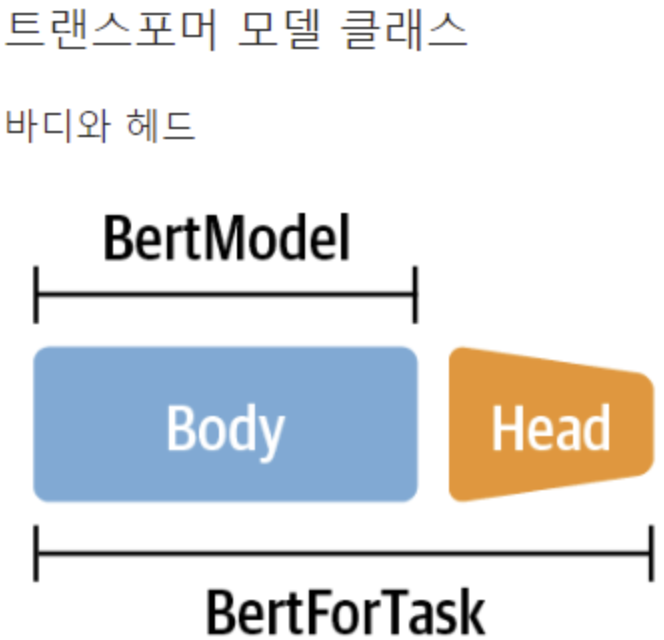

트랜스포머의 가장 큰 장점이라고 생각하는 모델의 구조  
Body는 이미 대용량 데이터로 사전 학습이 된 모델을 사용하고 마지막 Head를 내가 원하는 task로 학습을 시켜버림  
따라서 내가 원하는 특정 task에 맞는 모델로 변경가능  

In [1]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=4)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (335/335), done.
Updating files: 100% (118/118), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.41.2
Using datasets v2.20.0
Using accelerate v0.31.0
Using sentencepiece v0.1.99
Using seqeval


In [2]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig #표준 XLM-R 설정을 가져옴

    def __init__(self, config):
        super().__init__(config) #RobertaPreTrainedModel 클래스 초기화
        self.num_labels = config.num_labels #분류할 레이블 갯수 설정
        self.roberta = RobertaModel(config, add_pooling_layer=False) #Robert a 모델 가져와서 로드해줌 add_pooling_layer은 기본 true
        #만약 True라면 첫 번째 토큰의 은닉 상태만 밀집 층과 활성화 함수에 통과
        #FALSE이므로 모든 토큰의 은닉 상태를 출력
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()# 모델의 바디는 학습된 가중치 로드 헤드를 랜덤하게 초기

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # 모델 바디를 사용해 인코더 표현을 얻습니다.
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # 인코더 표현을 헤드에 통과시킵니다.
        sequence_output = self.dropout(outputs[0]) #여기서 왜 [0]을 넣어주지 일반적으로 그냥 출력을 넣던데
        # [batch,seq,hiden]같이 3차원이 아닌가? 맨 앞 차원에 1이 추가 된듯? 나중에 출력 차원을 프린트해봐야 함
        logits = self.classifier(sequence_output)
        # 손실을 계산합니다.
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # 모델 출력 객체를 반환합니다.
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

![image.png](attachment:12764f22-201a-490d-b93a-1958c3c34216.png)

In [3]:
from collections import defaultdict
from datasets import DatasetDict
from datasets import load_dataset
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# 키가 없는 경우 DatasetDict를 반환합니다.
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치를 로드합니다.
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # 각 분할을 언어 비율에 따라 다운샘플링하고 섞습니다.
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))
tags = panx_ch["de"]["train"].features["ner_tags"].feature

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [5]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)
print(tag2index)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


In [6]:
from transformers import AutoConfig
xlmr_model_name = "xlm-roberta-base"
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)
'''
AutoConfig는 모델 구조의 청사진을 가짐 model_name을 가진 것이 있으면 모델에 연관된 설정 파일이 자동으로 다운
'''

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

'\nAutoConfig는 모델 구조의 청사진을 가짐 model_name을 가진 것이 있으면 모델에 연관된 설정 파일이 자동으로 다운\n'

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))
'''

'''

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

'\n\n'

In [9]:
import pandas as pd
from transformers import AutoTokenizer
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
text = "Jack Sparrow loves New York!"
xlmr_tokens = xlmr_tokenizer(text).tokens()
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [10]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)#각 토큰에 대해 이게 뭔지 NER 하는 출력이 나옴
print(f"시퀀스에 있는 토큰 개수: {len(xlmr_tokens)}")
print(f"출력 크기: {outputs.shape}") #[batch,tokens,labels]

시퀀스에 있는 토큰 개수: 10
출력 크기: torch.Size([1, 10, 7])


In [11]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

'''
아직 분류 헤드가 학습이 안된 상태라서 당연히 답이 틀린게 맞음
'''

'\n아직 분류 헤드가 학습이 안된 상태라서 당연히 답이 틀린게 맞음\n'

In [12]:
def tag_text(text, tags, model, tokenizer):
    # 토큰을 준비합니다.
    tokens = tokenizer(text).tokens()
    # 시퀀스를 ID로 인코딩합니다.
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device) #위에서 사용한 xlmr_tokenizer.encode 랑 무슨 차이가 있는거임?
    # 가능한 일곱 개의 클래스에 대한 분포를 예측합니다.
    outputs = model(input_ids)[0]
    # 토큰마다 가장 가능성 있는 클래스를 argmax로 구합니다.
    predictions = torch.argmax(outputs, dim=2)
    # 데이터프레임으로 변환합니다.
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [13]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)
de_example = panx_de["train"][0]
words, labels = de_example["tokens"], de_example["ner_tags"]
print(words)
print(labels)

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']
[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]


In [14]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)#is_split_into_words 인자는 이미 단어로 나눠져 있어서 True
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [15]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])
# 단어 아이디는 토크나이저로 두 개의 부분 단어로 나눠진 '_Einwohner'와 'n'이 하나의 단어이며, 첫 번째 부분단어 이후 마스킹 단어임을 구분할 수 있는 기준임
# 내가 이해한게 맞다면 뒤에 n은 IGN 으로 마스킹 된다는 것

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [16]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx: # Word IDs가 이전과 같다면 -100으로 값을 넣어버림
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx]) #Word IDs가 이전과 다르다면 LABEL ids을 넣어줌
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids] #label ids에 맞게 tag로 바꿔줌
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

'''
왜 하필 -100으로 인덱스 하냐?
일반적으로 torch nn Cross entropyloss의 경우 ignore index 속성 기본값이 -100이기 때문에
훈련 하는동안 -100 인덱스는 전부 무시해버림
'''

'\n왜 하필 -100으로 인덱스 하냐?\n일반적으로 torch nn Cross entropyloss의 경우 ignore index 속성 기본값이 -100이기 때문에\n훈련 하는동안 -100 인덱스는 전부 무시해버림\n'

In [17]:
def tokenize_and_align_labels(examples): #위에서 했던거 전부 하나의 함수에 담아버림
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, #truncation는 일정 길이보다 긴 문장을 짤라버림
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [18]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [19]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [ ]:
panx_ch["de"]['train']

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 12580
})

In [ ]:
panx_de_encoded['train'] #여기서 attention_mask가 갑자기 어디서 나타난거임?

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12580
})

In [20]:
print(panx_de_encoded['train']['attention_mask'][:3])
'''
xlmr_tokenizer에서 나온거였음 truncation이 true로 되어있으니깐 그냥 잘려서 나오는데 만약 padding이 true였으면 늘린 부분은 0으로 만들어져있을거임
내가 생각한 그 Causal 마스크가 아니였음
'''

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1,
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


'\nxlmr_tokenizer에서 나온거였음 truncation이 true로 되어있으니깐 그냥 잘려서 나오는데 만약 padding이 true였으면 늘린 부분은 0으로 만들어져있을거임\n내가 생각한 그 Causal 마스크가 아니였음\n'

일반적으로 NER 성능 평가는 텍스트 분류 모델 평가와 비슷함   
정밀도, 재현율,f1 score를 사용함  
유일한 차이는 예측 하나를 정확하다고 판단하려면 한 문장의 전체 단어가 맞아야 올바르다고 판단함

In [21]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [22]:
import numpy as np

def align_predictions(predictions, label_ids): #위에서 사용한 성능 지표를 사용하기 위해 출력을 원하는 타입으로 바꾸는 함수
    preds = np.argmax(predictions, axis=2) #[batch,seq_len,label] 출력 모양인데 argmax 해서 [batch,seq_len]으로 바뀜
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # 레이블 IDs = -100 무시
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]]) #위에 y_true 같이 tag로 바꿔서 append 해줌
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

In [23]:
from transformers import TrainingArguments

num_epochs = 3
# 코랩에서 GPU 메모리 부족 에러가 나는 경우 batch_size를 16으로 줄여 주세요.
batch_size = 16  # 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
from huggingface_hub import notebook_login

notebook_login()

In [25]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [26]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)
#인자로 토크나이저를 받고 배치에서 가장 큰 시퀀스를 기준으로 입력을 패딩시킴 앞에서 본대로 -100으로 레이블을 만들어줌

In [27]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [28]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [29]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

In [30]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.257200,0.159798,0.817828
2,0.130200,0.149520,0.852400
3,0.078300,0.142225,0.864175


tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

events.out.tfevents.1719378762.eb46b788e4b6.720.0:   0%|          | 0.00/7.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/kwkwkwkwpark/xlm-roberta-base-finetuned-panx-de/commit/8dfe47018a11b450fdafb5abd00deaeb8273a86f', commit_message='Training completed!', commit_description='', oid='8dfe47018a11b450fdafb5abd00deaeb8273a86f', pr_url=None, pr_revision=None, pr_num=None)

In [31]:
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill() #ffill은 nan 값을 근처 값이랑 똑같이 따라함
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill() # bfill 결측값이 바로 아래값과 동일하게 설정됩니다.
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2572,0.159798,0.817828
2,2,0.1302,0.149520,0.852400
4,3,0.0783,0.142225,0.864175


In [32]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

'''
뭔가 이상함 제어 토큰들이 왜 인식되서 저렇게 학습 된거지??
어제 있던 코드에서 batch size만 수정했을 뿐인데 학습 결과가 달라짐
예측이 달라진거면 알겠는데 제어 토크들이 저리 된건 이해가 안됨
'''

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,B-PER,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,B-PER



# 오류 분석
학습이 잘 된 것처럼 보여도 실패 했을 때가있음 그래서 오류 분석이 중요함
*   우연히 너무 많은 토큰을 마스킹하고 일부 레이블들도 마스킹하여 제대로 훈련되는 것처럼 손실이 감소함
*   metrics 를 통한평가는 실제 성능을 과대평가하는 버그가 있음
*   NER에 0클래스 또는 0 개체명이 일반 클래스처럼 포함될 때가 있음. 압도적인 다수 클래스이므로 정확도와 F1 점수가 왜곡됨



In [33]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 리스트의 딕셔너리를 데이터 콜레이터에 적합한 딕셔너리의 리스트로 변환합니다.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # 입력과 레이블을 패딩하고 모든 텐서를 장치에 배치합니다.
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # 데이터를 모델에 전달합니다.
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # 마지막 축을 따라 가장 큰 로짓 값을 가진 클래스를 선택합니다.
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # 배치 차원을 펼친 다음 토큰마다 손실을 계산합니다.
    loss = cross_entropy(output.logits.view(-1, 7),
                         labels.view(-1), reduction="none")
    # 배치 차원을 다시 만들고 넘파이 배열로 변환합니다.
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [34]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [35]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)) #토큰 idx로 표현된거 원본 토크으로 바꿔주는 함수
df["predicted_label"] = df["predicted_label"].apply( # 예측한 레이블이 idx니까 tag로 바꿔줌
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])   #정답값 label도 숫자니까 tag로 바꿔줌
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.0061244196, 0.0, 0.009712582, 0.007733...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [36]:
df_tokens = df.apply(pd.Series.explode) #한 줄 코드로 리스트에 있는 각 원소를 하나의 행으로 만듬 데이터 길이가 전부 같아야함
df_tokens = df_tokens.query("labels != 'IGN'") #IGN으로 표시된 토큰은 무시함 <S> /S 같은거
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)
'''
데이터를 이렇게 만들면 토큰 개수 토큰 손실의 평균과 합 계산이 편해짐, 행으로 나타나니깐 당연하지
'''

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.29,B-LOC,▁Luz
1,10,1,I-ORG,1.10,I-LOC,▁a


In [37]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # 멀티 컬럼을 삭제합니다.
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
) #가장 큰 loss를 보여주는 토큰들을 정렬해서 10개 뽑음
#당연히 공백 토큰이 가장큼 근데 IGN이라서 무시함 평균 손실을 보면 아예 무시하고 있는걸 보여줌
#접미사의 특정 종류가 많이 등장함 아마 개체명과 개체명의 일부인 경우가 많아서 모델이 혼동하는듯 (접두사냐 접미사냐)
#단어 시작부분의 괄호 슬래시 대문자는 드물지만 손실이 높게 잡히고 있음 조사해보자

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁und,▁/,▁(,▁),▁'',▁A
count,6066,989,1388,808,1171,163,246,246,2898,125
mean,0.04,0.15,0.1,0.16,0.09,0.58,0.33,0.3,0.02,0.47
sum,213.96,148.83,143.77,133.01,100.47,95.08,80.2,73.81,63.77,58.79


In [38]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)
#책과 다르게 1등 2등이 바뀌어버림
#뭐 둘다 문제있는건 보이니깐 상관없을듯
#

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.66,0.62,0.52,0.35,0.24,0.2,0.03
sum,965.8,1650.71,1971.11,1124.66,692.69,826.21,1449.37


In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

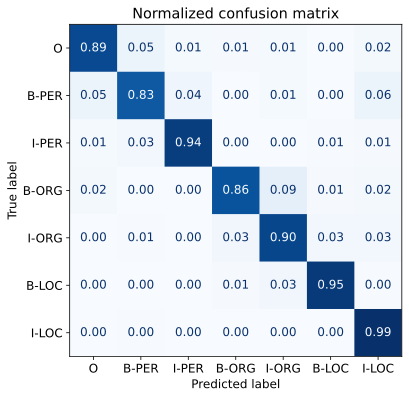

In [40]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [41]:

def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)
'''
레이블들이 문제가 많음 3번째 보면 united nations가 per로 맵핑됨 (UN 기구)
사용한 데이터셋 PAN-X이 레이블을 자동으로 생성하며 생긴 문제같음

레이블을 자동으로 생성-> 실버 스탠다드
레이블을 사람이 생성 -> 골드 스탠다드

레이블 문제는 어디서든 생길수있음
'''

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.87,0.00,0.00,0.00,11.43,10.31,8.16,7.75,8.63,0.00,7.15,8.53,0.00,8.12,8.65,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,7.52,0.00,0.00,7.64,9.08,9.09,6.82,0.00,7.13,9.71,7.66,6.85,5.46,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.71,6.78,6.60,0.00,6.65,0.00,6.37,0.00,5.91,5.95,5.99,6.24,6.31,5.98,0.00


In [42]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

#괄호 안에 포함된 단어의 레이블로 인해 생기는 손실이 굉장히 큼
#괄호 안에 단어는 상황에 따라 너무 쓰임이 달라서 생기는듯?
#이걸 위해 다양한 방법으로 데이터를 정제해야함

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00


In [43]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [44]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"[de] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['de']:.3f}")
#F1 점수 0.872점
#일반적인 NER 작업에서 이정도면 괜찮은 점수
#ORG가 훈련 데이터가 적고 조직명이 너무 많은데 어휘 사전에서는 모든 정보가 없기 때문에 문제가 생김 특히 ORG에서 가장 큰 어려움 겪음
#다른 언어는 어떨까? 지금은 독일어 였음 프랑스어로 미세튜닝 진행

[de] 데이터셋에서 [de] 모델의 F1-점수: 0.872


In [45]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,B-PER,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,B-PER


In [46]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"[fr] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

[fr] 데이터셋에서 [de] 모델의 F1-점수: 0.695


In [47]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"[it] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

[it] 데이터셋에서 [de] 모델의 F1-점수: 0.677


In [48]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"[en] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

[en] 데이터셋에서 [de] 모델의 F1-점수: 0.587


위에 결과들을 보면 우리는 독일어 데이터만 이용해서 학습을 진행했음   
그런데 다른 나라 언어도 성능이 좋지않지만 일단 가능 하다는 것을 보여줌
이렇게 시행해본게 **제로 샷 전이 학습**임  
추가 학습 없이 다른 데이터 이용해서 결과만 보는 것

In [49]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [50]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [51]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.531600,1.132142,0.128462
2,1.027600,0.823658,0.484246
3,0.778500,0.694999,0.608382


,num_samples,f1_score
0,250,0.609427


In [52]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = pd.concat([
        metrics_df,
        train_on_subset(panx_fr_encoded, num_samples)])


Epoch,Training Loss,Validation Loss,F1
1,1.278200,0.797507,0.388912
2,0.627400,0.490160,0.683867
3,0.365300,0.453694,0.714332


Epoch,Training Loss,Validation Loss,F1
1,0.922100,0.442457,0.723760
2,0.393000,0.402353,0.739762
3,0.250100,0.380531,0.775132


Epoch,Training Loss,Validation Loss,F1
1,0.674600,0.384874,0.735463
2,0.295800,0.332305,0.787065
3,0.200400,0.335507,0.824178


Epoch,Training Loss,Validation Loss,F1
1,0.536900,0.354022,0.783865
2,0.268500,0.328509,0.817770
3,0.168300,0.288892,0.841804


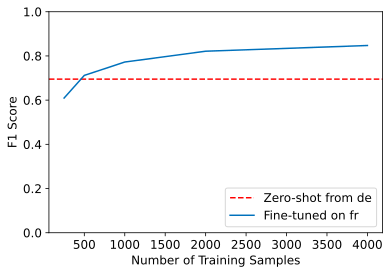

In [53]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()
'''
추가 학습 시킨 것 데이터가 많을수록 학습은 잘됨 근데 이게 의미있나 독일어도 마저 잘하나?
'''

In [54]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus
'''
들어오는 데이터를 랜덤하게 합치고 셔플
'''

In [55]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [56]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.282900,0.183720,0.823808
2,0.149800,0.174800,0.851626
3,0.091900,0.170718,0.862490


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kwkwkwkwpark/xlm-roberta-base-finetuned-panx-de-fr/commit/c3973ba5c166513dd146de7ec65e5053d8f62954', commit_message='Training completed!', commit_description='', oid='c3973ba5c166513dd146de7ec65e5053d8f62954', pr_url=None, pr_revision=None, pr_num=None)

In [57]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"[{lang}] 데이터셋에서 [de-fr] 모델의 F1-점수: {f1:.3f}")

'''
독일어랑 프랑스어로 학습을 시켯는데 이탈리아어랑 영어의 성능까지 올라가버림
다중 언어 학습이 되고있
'''

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

[de] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.868


[fr] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.867


[it] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.817


[en] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.676


In [59]:
corpora = [panx_de_encoded]

# 반복에서 독일어는 제외합니다.
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # 단일 언어 말뭉치에서 미세 튜닝합니다.
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # 딕셔너리에 F1-점수를 모읍니다.
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # 단일 언어 말뭉치를 corpora 리스트에 추가합니다.
    corpora.append(ds_encoded)


#모든 언어에 대하여 미세 튜닝 진행

Epoch,Training Loss,Validation Loss,F1
1,0.540300,0.320588,0.794872
2,0.267200,0.298676,0.807239
3,0.176900,0.287660,0.842194


Epoch,Training Loss,Validation Loss,F1
1,0.621500,0.292071,0.785657
2,0.246700,0.263483,0.798381
3,0.153200,0.247814,0.842452


Epoch,Training Loss,Validation Loss,F1
1,0.964700,0.462147,0.617442
2,0.457100,0.401364,0.698985
3,0.325500,0.390245,0.709060


In [60]:
corpora_encoded = concatenate_splits(corpora)

In [61]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")
#진짜 모든 언어 통합해서 학습 진행 오래걸리긴하

Epoch,Training Loss,Validation Loss,F1
1,0.289300,0.201357,0.814758
2,0.158700,0.177726,0.842664
3,0.101500,0.185111,0.854448


Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kwkwkwkwpark/xlm-roberta-base-finetuned-panx-all/commit/37111c6b47136de9b3cb4bfa36f78306ed3cb706', commit_message='Training completed!', commit_description='', oid='37111c6b47136de9b3cb4bfa36f78306ed3cb706', pr_url=None, pr_revision=None, pr_num=None)

In [62]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [63]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

'''
결과를 보면 독일어,프랑스어,이탈리아어 는 비슷한 성능을 보여줌 하지만 영어는 비교적 낮음
일반적인 전략으로 일본어처럼 다른 종류의 텍스트를 다룰 때는 한 어족 내에서 교차 언어 전이에 초점을 맞추는 것이 좋습니다.(한국어,중국어,일본어)
'''

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8719,0.6950,0.6774,0.5867
each,0.8719,0.8488,0.8259,0.7132
all,0.8653,0.8692,0.8740,0.7701
